In [21]:
%cd /content/drive/MyDrive/Digital_Image_Processing_EE608

/content/drive/MyDrive/Digital_Image_Processing_EE608


In [27]:
!git push

Enumerating objects: 18, done.
Counting objects: 100% (18/18), done.
Delta compression using up to 2 threads
Compressing objects: 100% (15/15), done.
Writing objects: 100% (15/15), 11.26 MiB | 9.67 MiB/s, done.
Total 15 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/shashankkapoor/Digital_Image_Processing_EE608.git
   7309aca..6744858  master -> master


In [24]:
!git config --global user.email "Shashankkapoor1994@gmail.com"
!git config --global user.name  "Shashank kapoor"

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy import signal
import cv2  # for Hough Transform only
import random
import numpy as np
from scipy import ndimage
from skimage.morphology import square, rectangle, closing, opening

In [ ]:
''' change the path here to run the below code
'''
gray_image_path="/content/drive/MyDrive/Images_HWS/DIP_gray_scales/Cameraman - Copy.tif"

In [ ]:
# import cv2
# from google.colab.patches import cv2_imshow

# # Open the video file
# video = cv2.VideoCapture('/content/drive/MyDrive/Digital_Image_Processing_EE608/s22022_hw4/videoplayback.mp4')

# # Initialize a frame counter
# frame_count = 0

# # Loop through the video frames
# while True:
#     # Read the next frame from the video
#     ret, frame = video.read()
    
#     # If the frame cannot be read, break the loop
#     if not ret:
#         break
    
#     # Increment the frame counter
#     frame_count += 1
    
#     # Write the frame to a file
#     cv2.imwrite(f"/content/drive/MyDrive/Digital_Image_Processing_EE608/s22022_hw4/frame_{frame_count}.jpg", frame)
    
#     # Display the frame
#     cv2_imshow(frame)
    
#     # Wait for a key press to exit
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# # Release the video file and destroy the window
# video.release()
# cv2.destroyAllWindows()


# Problem 0: Panorama Stitching

#### 1. Take multiple images with some overlap. Perform image stitching and panorama construction. Clearly describe the steps in your implementation. Write down your observations at each step. (10) (Use OpenCV or any Library) [steps: 1.SIFT-feature extraction, 2.Feature Matching,3.RANSAC algorithm, 4.Geometric matrix estimation, 5.Image Registration

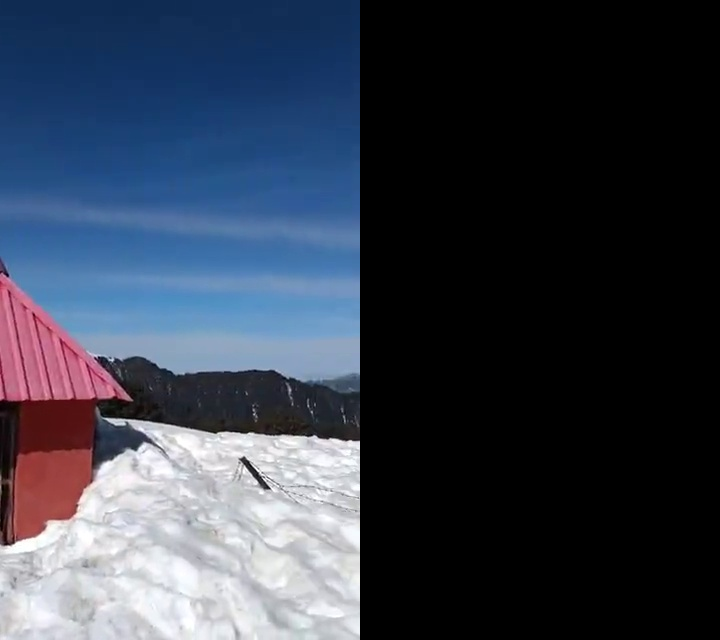

In [20]:
import cv2
from google.colab.patches import cv2_imshow

# Load input images
image1 = cv2.imread('/content/drive/MyDrive/Digital_Image_Processing_EE608/s22022_hw4/frame_1.jpg')
image2 = cv2.imread('/content/drive/MyDrive/Digital_Image_Processing_EE608/s22022_hw4/frame_44.jpg')

# Convert images to grayscale
gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

# Create SIFT object
sift = cv2.xfeatures2d.SIFT_create()

# Detect keypoints and extract features
keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)

# Create feature matcher object
matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)

# Match features between images
matches = matcher.knnMatch(descriptors1, descriptors2, k=2)

# Apply ratio test to filter out bad matches
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

# Use RANSAC to estimate homography matrix
src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
homography, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# Warp images using homography matrix
height, width, channels = image2.shape
panorama = cv2.warpPerspective(image1, homography, (width * 2, height))

# Combine images
panorama[0:height, 0:width] = image2

# Display result
cv2_imshow(panorama)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Problem 1: Motion Estimation

#### In this problem you will implement the most critical part of the video codec the motion estimator. Do the following:

####1. Use the 3-step search to find motion vectors (check slides for description). (10)
####• Use mean absolute distance (MAD) as your metric.
####• Step 1: Search at 8 location ±4 pixels around current macroblock including (0, 0) (relative to current macroblock).
####• Step 2: search at 8 location ±2 pixels around best match location in Step 1 including best match location.
####• Step 3: search at 8 location ±1 pixels around best match location in Step 2 including best match location.

#### 2. Plot the motion vector at each macroblock. You can use the arrow function in matplotlib. (1)

#### 3. Generate the motion compensated predicted frame using the motion vectors and the first frame. (3)

####4. Compute the error between the second frame and its motion compensated predicted version and display it.(1)
####Instructions:
####• Do not use built-in functions.
####• Divide each frame into non-overlapping macroblocks of size 16×16 pixels. Note that the images are of size 176 × 144.
####• Generate motion vectors at each macroblock in the second frame from the first

# Problem 2: Optical Flow

#### 1.[Theory] - Define Optical Flow Equation? Explain Lucas-Kanade algorithm?

In [1]:
'''
1. Optical flow equation:
The optical flow equation relates the motion of pixels between two consecutive frames in an image sequence:

I(x,y,t) = I(x+dx,y+dy,t+dt)

where I(x,y,t) is the intensity of a pixel at position (x,y) and time t, and dx, dy, and dt are the corresponding spatial and 
temporal derivatives of the flow field.

2.Lucas-Kanade algorithm:

The Lucas-Kanade algorithm estimates the optical flow using the following equation:

∑∇I(x,y) [ u v ] = -∑I(x,y,t) ∇I(x,y,t)

where ∇I(x,y) is the gradient of the image at position (x,y), [u v] is the optical flow vector at position (x,y), and ∑ is the 
summation over a local neighborhood around (x,y). The algorithm solves this equation using the least-squares method to obtain the
optical flow vector [u v].

The algorithm also involves a Gaussian smoothing function to reduce the influence of noise and outliers:

∑∇I(x,y) [ u v ] = -∑I(x,y,t) ∇I(x,y,t)

where G(x,y) is a Gaussian smoothing kernel and σ is the standard deviation of the kernel.

The algorithm iteratively refines the optical flow estimates by repeating the above steps on multiple pyramid levels to handle large 
displacements and occlusions.

'''

' Ans.\n\n'

#### 2. [Coding] - Take two videos 1) Slow motion video 2) Fast moving video. Compute optical flow between consecutive frames for the entire video? Visualize optical flow maps and Comment on the magnitude of the optical flow for both the videos? [Use Open-CV/Any Python library]

In [8]:
import cv2
import numpy as np

# Load the video file
cap = cv2.VideoCapture('/content/drive/MyDrive/Digital_Image_Processing_EE608/s22022_hw4/slow_video.mp4')

# Define parameters for the optical flow algorithm
lk_params = dict(winSize=(15, 15),
                 maxLevel=4,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Take the first frame and convert it to grayscale
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

# Define the initial points to track
p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, maxCorners=100, qualityLevel=0.3,
                              minDistance=7, blockSize=7)

# Create an empty list to store the optical flow vectors
optical_flow_vectors = []

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the frame to grayscale
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Compute the optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

    # Select good points
    good_new = p1[st == 1]
    good_old = p0[st == 1]

    # Compute the optical flow vectors
    optical_flow = good_new - good_old

    # Append the optical flow vectors to the list
    optical_flow_vectors.append(optical_flow)

    # Update the previous frame and points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)

# Convert the list of optical flow vectors to a numpy array
optical_flow_vectors = np.array(optical_flow_vectors)

# Save the optical flow vectors to a file
np.save('optical_flow_vectors.npy', optical_flow_vectors)

# Release the video capture object
cap.release()


<ipython-input-8-cbc42fdd5677>:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  optical_flow_vectors = np.array(optical_flow_vectors)


In [9]:
import cv2
import numpy as np

# Load the video file
cap = cv2.VideoCapture('/content/drive/MyDrive/Digital_Image_Processing_EE608/s22022_hw4/slow_video.mp4')

# Define parameters for the optical flow algorithm
lk_params = dict(winSize=(15, 15),
                 maxLevel=4,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Take the first frame and convert it to grayscale
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

# Define the initial points to track
p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, maxCorners=100, qualityLevel=0.3,
                              minDistance=7, blockSize=7)

# Create an empty list to store the optical flow vectors
optical_flow_vectors = []

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the frame to grayscale
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Compute the optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

    # Select good points
    good_new = p1[st == 1]
    good_old = p0[st == 1]

    # Compute the optical flow vectors
    optical_flow = good_new - good_old

    # Append the optical flow vectors to the list
    optical_flow_vectors.append(optical_flow)

    # Draw the optical flow on the frame
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel()
        c, d = old.ravel()
        mask = cv2.line(mask, (a, b), (c, d), (0, 255, 0), 2)
        frame = cv2.circle(frame, (a, b), 5, (0, 0, 255), -1)
    img = cv2.add(frame, mask)

    # Show the optical flow map
    cv2.imshow('Optical flow map', img)

    # Update the previous frame and points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)

    # Wait for a key press
    if cv2.waitKey(1) == ord('q'):
        break

# Release the video capture object
cap.release()

# Close all windows
cv2.destroyAllWindows()

error: ignored

In [15]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Load the video file
cap = cv2.VideoCapture('/content/drive/MyDrive/Digital_Image_Processing_EE608/s22022_hw4/Fast_video.mp4')

# Define parameters for the optical flow algorithm
lk_params = dict(winSize=(15, 15),
                 maxLevel=4,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Take the first frame and convert it to grayscale
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

# Define the initial points to track
p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, maxCorners=100, qualityLevel=0.3,
                              minDistance=7, blockSize=7)

# Create an empty list to store the optical flow vectors
optical_flow_vectors = []

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the frame to grayscale
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Compute the optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

    # Select good points
    good_new = p1[st == 1]
    good_old = p0[st == 1]

    # Compute the optical flow vectors
    optical_flow = good_new - good_old

    # Append the optical flow vectors to the list
    optical_flow_vectors.append(optical_flow)

    # Draw the optical flow on the frame
    mask = np.zeros_like(old_frame)
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel().astype(int)
        c, d = old.ravel().astype(int)
        mask = cv2.line(mask, (a, b), (c, d), (0, 255, 0), 2)
        frame = cv2.circle(frame, (a, b), 5, (0, 0, 255), -1)
    img = cv2.add(frame, mask)

    # Show the optical flow map
    cv2_imshow(img)

    # Update the previous frame and points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)

    # Wait for a key press
    if cv2.waitKey(1) == ord('q'):
        break

# Release the video capture object
cap.release()

# Close all windows
cv2.destroyAllWindows()


Output hidden; open in https://colab.research.google.com to view.

# Problem 3: Wavelet Transform

#### 1. [Theory] - Explain 2D-Wavelet Transform & 2D-Inverse Wavelet Transform?

In [1]:
'''
The 2D wavelet transform is a signal processing technique used for image compression, feature extraction, and denoising. It involves decomposing a 
two-dimensional image into a series of wavelet coefficients at different scales and orientations. The wavelet coefficients represent the image content
at different levels of detail. The transform can be computed using a bank of filters, typically consisting of a low-pass filter and high-pass filter in 
both horizontal and vertical directions.

The 2D wavelet transform can be performed using the following steps:

1. Decompose the image into its low-pass and high-pass components in both horizontal and vertical directions using a set of filters. This is often referred 
to as a convolution operation.
2. Repeat the above step on the low-pass image to obtain the next level of wavelet coefficients.
3. Continue the above steps until the desired level of decomposition is reached.

The 2D inverse wavelet transform is used to reconstruct the original image from the wavelet coefficients. It involves performing a series of inverse filtering 
operations, starting from the highest level of decomposition, until the original image is obtained. The inverse wavelet transform can be expressed as a linear 
combination of scaling and wavelet functions, with the scaling function providing the low-pass component and the wavelet function providing the high-pass component.

The 2D inverse wavelet transform can be performed using the following steps:

1. Reconstruct the image at the highest level of decomposition using the wavelet coefficients and the corresponding filters.
2. Repeat the above step for each level of decomposition, using the wavelet coefficients and filters at that level.
3. Sum the reconstructed images at each level of decomposition to obtain the final reconstructed image.

Overall, the 2D wavelet transform and 2D inverse wavelet transform are powerful tools for image compression and feature extraction, and have been widely used in
many areas of signal processing and computer vision.
'''

'\nThe 2D wavelet transform is a signal processing technique used for image compression, feature extraction, and denoising. It involves decomposing a \ntwo-dimensional image into a series of wavelet coefficients at different scales and orientations. The wavelet coefficients represent the image content\nat different levels of detail. The transform can be computed using a bank of filters, typically consisting of a low-pass filter and high-pass filter in \nboth horizontal and vertical directions.\n\nThe 2D wavelet transform can be performed using the following steps:\n\n1. Decompose the image into its low-pass and high-pass components in both horizontal and vertical directions using a set of filters. This is often referred \nto as a convolution operation.\n2. Repeat the above step on the low-pass image to obtain the next level of wavelet coefficients.\n3. Continue the above steps until the desired level of decomposition is reached.\n\nThe 2D inverse wavelet transform is used to reconstruc

#### 2. Implement Wavelet Transform using the library (OpenCV/Pywavelet)? Implement image denoising algorithm using the Wavelet Transform? (https://pywavelets.readthedocs.io/en/latest/ref/2d-dwt-and-idwt.html)

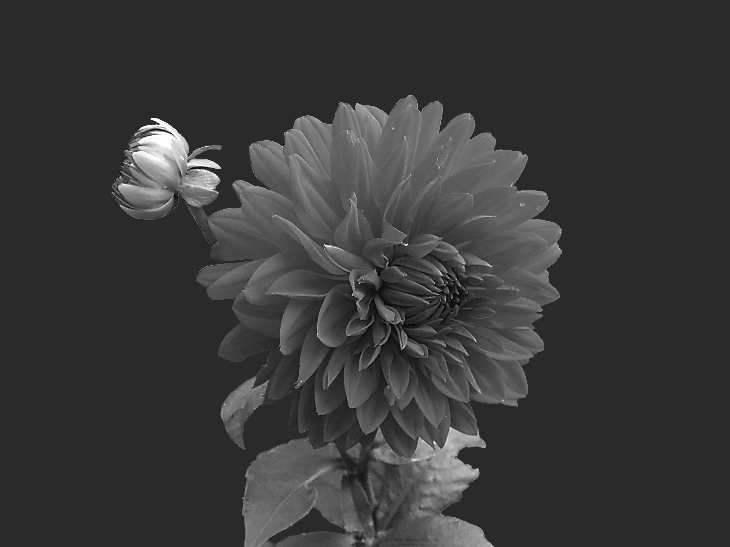

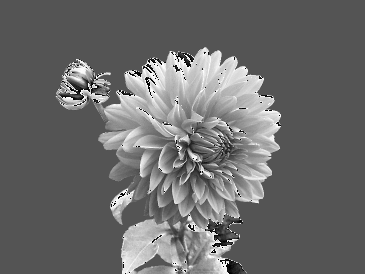

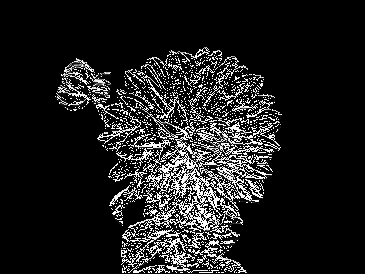

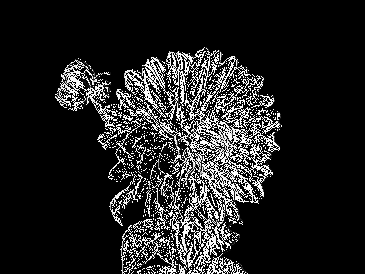

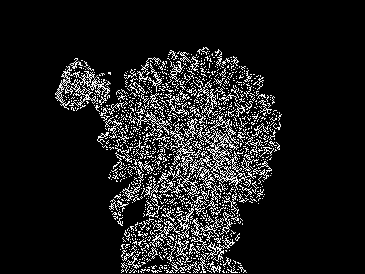

In [13]:
import pywt
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

img = cv2.imread('/content/drive/MyDrive/Digital_Image_Processing_EE608/s22022_hw4/Flower.jpg', 0)
img = cv2.resize(img, None, fx=0.2, fy=0.2)
coeffs = pywt.dwt2(img, 'haar')

LL, (LH, HL, HH) = coeffs

cv2_imshow(img)
cv2_imshow(LL.astype(np.uint8))
cv2_imshow(LH.astype(np.uint8))
cv2_imshow(HL.astype(np.uint8))
cv2_imshow(HH.astype(np.uint8))
cv2.waitKey(0)
cv2.destroyAllWindows()
